## An approach to recognize masked face using Deep Learning

## CNN

- **Input dimension:**
  - Size of image: $64 \times 64 = 4096$

- **Output dimension: 2**
  - 0, 1

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/4.2/CSE 4238 - Soft Computing Lab/Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

### ROC AUC Curve

In [ ]:
def plotROC(y_test, y_pred):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  plt.figure(figsize=(4,4))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr,tpr, color='red',label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],linestyle='--')
  plt.axis('tight')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### Precision and Recall Curve

In [ ]:
def plotPrecisionRecall(y_test, y_pred):
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  plt.figure(figsize = (4,4))
  plt.plot(recall, precision)
  plt.plot([0, 1], [0.5, 0.5], linestyle = '--')
  plt.axis('tight')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.show()

### Prediction

In [ ]:
def get_all_prediction(loader):
  predictions_list = torch.tensor([], dtype=torch.int32)
  labels_list = torch.tensor([], dtype=torch.int32)
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predictions = torch.max(outputs.data, 1)
    predictions_list = torch.cat((predictions_list, predictions.cpu()), dim = 0)
    labels_list = torch.cat((labels_list.cpu(), labels.cpu()), dim = 0).to(device)
  return predictions_list, labels_list.cpu()

### Loading Dataset 

In [ ]:
df1 = pd.read_csv(root_path + 'Dataset/with_mask_img_pixels.csv')
df2 = pd.read_csv(root_path + 'Dataset/without_mask_img_pixels.csv')

### Splitting Dataset

In [ ]:
train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)
train2, test2 = train_test_split(df2, test_size=0.2, random_state=42)
train = pd.concat([train1, train2])
test = pd.concat([test1, test2])

### Making Loader

In [ ]:
X_data = train.drop("label", axis=1).values.astype(np.uint8)
y_data = train["label"].values.astype(np.uint8)

X_test = test.drop("label", axis=1).values.astype(np.uint8)
y_test = test["label"].values.astype(np.uint8)

In [ ]:
class ProjectDataset(Dataset):
  def __init__(self, X, y, transforms):
    self.X = X
    self.y = y
    self.transforms = transforms

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    X = np.reshape(self.X[idx], (64, 64, 1))
    X = self.transforms(X)
    return X, self.y[idx]

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(), # value convert from 0-255 to 0-1(normalize)
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train = ProjectDataset(X=X_data, y=y_data, transforms=transform_test)
test = ProjectDataset(X=X_test, y=y_test, transforms=transform_test)

# prepare loaders
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Hyper parameters

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper parameters
num_epochs = 100
num_classes = 2
batch_size = 100
learning_rate = 0.001 # More power so we can learn faster! previously it was 0.001

startingEpoch = 0
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
iter = 0
load_model = os.path.isfile(root_path + 'Project_Checkpoint1.pth.tar')

### Step #1 : Design model using class

In [ ]:
#credit: https://github.com/yunjey/pytorch-tutorial/
# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),      #in_channels, out_channels ,
            nn.Tanh(),     
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), 
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.Tanh(),      
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.Tanh(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), 
            nn.Tanh(),    
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.Tanh(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten()
        self.denseLayer1 = nn.Sequential(
            nn.Linear(512, 100),
            nn.Tanh(),     
            nn.Dropout(0.1))
        self.denseLayer2 = nn.Sequential(
            nn.Linear(100, 30),
            nn.Tanh(),     
            nn.Dropout(0.1))
        self.denseLayer3 = nn.Sequential(
            nn.Linear(30, 10), 
            nn.Tanh(),     
            nn.Dropout(0.1))
        self.fc = nn.Linear(10, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.flatten(out)
        out = self.denseLayer1(out)
        out = self.denseLayer2(out)
        out = self.denseLayer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)

        return out

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = ConvNet(num_classes).to(device)

# To enable GPU
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (denseLayer1): Sequential(
    (0): Linear(in_features=512, out_features=100, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
  )
  (denseLa

### Model Summary

In [ ]:
summary(model, (1, 64, 64))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             320
              Tanh-2           [-1, 32, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           9,248
              Tanh-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 32, 28, 28]           9,248
              Tanh-7           [-1, 32, 28, 28]               0
            Conv2d-8           [-1, 32, 26, 26]           9,248
              Tanh-9           [-1, 32, 26, 26]               0
        MaxPool2d-10           [-1, 32, 13, 13]               0
           Conv2d-11           [-1, 32, 11, 11]           9,248
             Tanh-12           [-1, 32, 11, 11]               0
           Conv2d-13             [-1, 32, 9, 9]           9,248
             Tanh-14             [-1, 3

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Step #2 : Construct loss and optimizer

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax ([Logistic or Sigmoid]/softmax function)
2. Computes Cross Entropy Loss

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

### Step #3 : Training: forward, loss, backward, step

In [ ]:
# Train the model
if os.path.isfile(root_path + 'Project_Checkpoint1.pth.tar'):
  checkpoint = torch.load(root_path + 'Project_Checkpoint1.pth.tar')
  print("=> Loading checkpoint")
  print(str(checkpoint['epoch'])+' epoch completed so far.')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  loss = checkpoint['loss']
  startingEpoch = checkpoint['epoch']
  train_loss = checkpoint['train_loss']
  train_accuracy = checkpoint['train_accuracy']
  test_loss = checkpoint['test_loss']
  test_accuracy = checkpoint['test_accuracy']
  model.train()
if startingEpoch + 1 < num_epochs:
  for epoch in range(startingEpoch, num_epochs):
    correct = 0
    total = 0
    running_loss=0
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
      else:
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    train_loss.append(running_loss/len(train_loader))
    train_accuracy.append(accuracy)

    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
      
      images = images.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      # Forward pass only to get logits/output
      outputs = model(images)

      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
      else:
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    
    # Print Loss
    test_loss.append(loss.item())
    test_accuracy.append(accuracy)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch + 1, loss.item(), accuracy))
    checkpoint = {'epoch': epoch, 
                  'model_state_dict': model.state_dict(), 
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss,
                  'train_loss': train_loss,
                  'train_accuracy': train_accuracy,
                  'test_loss': test_loss,
                  'test_accuracy': test_accuracy}
    print("=> Saving checkpoint of epoch " + str(epoch + 1))
    torch.save(checkpoint, root_path + 'Project_Checkpoint1.pth.tar')

Epoch: 1. Loss: 0.5377570986747742. Accuracy: 79.6116504854369
=> Saving checkpoint of epoch 1
Epoch: 2. Loss: 0.46219056844711304. Accuracy: 87.05501618122977
=> Saving checkpoint of epoch 2
Epoch: 3. Loss: 0.27433863282203674. Accuracy: 88.3495145631068
=> Saving checkpoint of epoch 3
Epoch: 4. Loss: 0.20862627029418945. Accuracy: 89.96763754045307
=> Saving checkpoint of epoch 4
Epoch: 5. Loss: 0.13220354914665222. Accuracy: 91.58576051779936
=> Saving checkpoint of epoch 5
Epoch: 6. Loss: 0.13173657655715942. Accuracy: 86.40776699029126
=> Saving checkpoint of epoch 6
Epoch: 7. Loss: 0.20100268721580505. Accuracy: 90.93851132686085
=> Saving checkpoint of epoch 7
Epoch: 8. Loss: 0.18105117976665497. Accuracy: 89.32038834951456
=> Saving checkpoint of epoch 8
Epoch: 9. Loss: 0.11566345393657684. Accuracy: 89.32038834951456
=> Saving checkpoint of epoch 9
Epoch: 10. Loss: 0.3316870331764221. Accuracy: 93.85113268608414
=> Saving checkpoint of epoch 10
Epoch: 11. Loss: 0.2562454640865

### Iteration Vs Loss

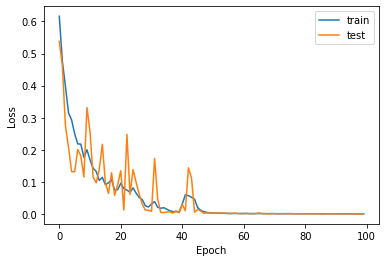

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Iteration Vs Accuracy

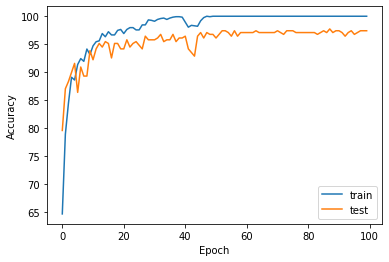

In [ ]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Save Model

In [ ]:
save_model = True

if save_model is True:
  # Saves only parameters
  # weights & biases
  torch.save(model.state_dict(), root_path + 'Project1.pkl')

### Load Model

In [ ]:
load_model = True

if load_model is True:
  model.load_state_dict(torch.load(root_path + 'Project1.pkl'))
  print('Trained Model Loaded')

Trained Model Loaded


### Testing Loaded Model

In [ ]:
y_pred, y_true = get_all_prediction(test_loader)

Accuracy: 0.9741
Precision: 0.9741
Recall: 0.9741
F1 score: 0.9741


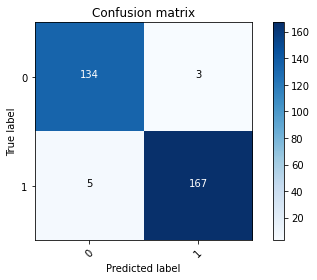

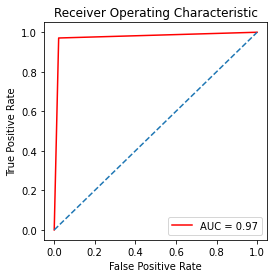

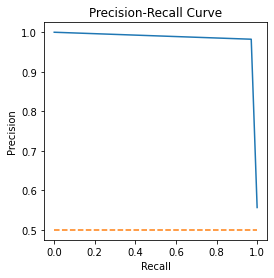

In [ ]:
print('Accuracy: ' +str(round(accuracy_score(y_true, y_pred), 4)))
print('Precision: ' +str(round(precision_score(y_true, y_pred, average='micro'), 4)))
print('Recall: ' +str(round(recall_score(y_true, y_pred, average='micro'), 4)))
print('F1 score: ' +str(round(f1_score(y_true, y_pred, average='micro'), 4)))
confusion_mtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2))
plotROC(y_test, y_pred)
plotPrecisionRecall(y_test, y_pred)

### User Prediction

In [ ]:
def test(file):
  img_original = Image.open(file)
  img_file = Image.open(file).resize((64, 64))
  img_grey = img_file.convert('L')
  img = transform_test(img_grey)
  img = torch.unsqueeze(img, 0)
  images = img.to(device)
  outputs = model(images)
  _, predictions = torch.max(outputs, 1)
  if predictions.item() == 1:
    print('Person wears the mask correctly')
  else:
    print('Person did not wear the mask')
  plt.axis('off')
  plt.imshow(img_original)
  plt.show()

Person wears the mask correctly


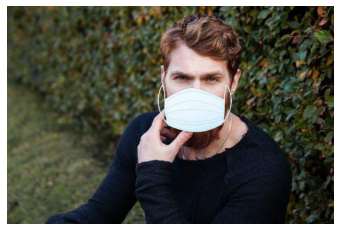

In [ ]:
test('/content/drive/MyDrive/4.2/CSE 4238 - Soft Computing Lab/Project/Dataset/with_mask/0-with-mask.jpg')

Person did not wear the mask


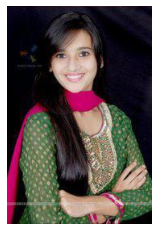

In [ ]:
test('/content/drive/MyDrive/4.2/CSE 4238 - Soft Computing Lab/Project/Dataset/without_mask/0.jpg')

#Live Link:- https://mask-deetection.herokuapp.com/